In [13]:
import numpy as np
import pandas as pd
from datetime import datetime
import plotly.graph_objects as go
from utils.scenario_creator import create_weather_BMG_scens, plot_pdf
from utils.functions import get_data_fromNSRDB
import json
import time

# Crear escenarios meteorológicos

### Seleccionar ubicación

In [14]:
location = {"lat":6.189, "lon":-67.485, "name":"Puerto Carreño"}
#location = {"lat":12.583, "lon":-81.706, "name":"San Andrés"}

### Importar datos de la NSRDB

In [15]:
df = pd.DataFrame()

for i in [2015,2016,2017,2018,2019,2020]:
    df2, info2 = get_data_fromNSRDB(location["lat"], location["lon"], i)
    time.sleep(2)
    df = pd.concat([df, df2])

date_vec = np.vectorize(datetime)
df_index = date_vec(df.Year.values,df.Month.values,df.Day.values, df.Hour.values, df.Minute.values, tzinfo=None)
df.index = df_index

df

Year  Month  Day  Hour  Minute  GHI  DHI  DNI  \
2015-01-01 00:00:00  2015      1    1     0       0    0    0    0   
2015-01-01 01:00:00  2015      1    1     1       0    0    0    0   
2015-01-01 02:00:00  2015      1    1     2       0    0    0    0   
2015-01-01 03:00:00  2015      1    1     3       0    0    0    0   
2015-01-01 04:00:00  2015      1    1     4       0    0    0    0   
...                   ...    ...  ...   ...     ...  ...  ...  ...   
2020-12-31 19:00:00  2020     12   31    19       0    0    0    0   
2020-12-31 20:00:00  2020     12   31    20       0    0    0    0   
2020-12-31 21:00:00  2020     12   31    21       0    0    0    0   
2020-12-31 22:00:00  2020     12   31    22       0    0    0    0   
2020-12-31 23:00:00  2020     12   31    23       0    0    0    0   

                     Wind Speed  Temperature  Solar Zenith Angle  
2015-01-01 00:00:00         1.3         23.0              161.95  
2015-01-01 01:00:00         1.3         22.0              153.17  
2015-01-01 02:00:00         1.3         22.0              140.89  
2015-01-01 03:00:00         1.3         22.0              127.56  
2015-01-01 04:00:00         1.3         21.0              113.86  
...                         ...          ...                 ...  
2020-12-31 19:00:00         1.0         26.1              112.38  
2020-12-31 20:00:00         1.0         25.6              126.09  
2020-12-31 21:00:00         1.1         25.2              139.48  
2020-12-31 22:00:00         1.0         24.8              151.93  
2020-12-31 23:00:00         1.0         24.4              161.33  

[52560 rows x 11 columns]

### Gráficas de los históricos

In [16]:
# FIGURA IRRADIANCIA
fig = go.Figure(data=[go.Scatter(x = df.index, y=df["GHI"], name='GHI')])
fig.update_layout(title=f'Irradiancia en {location["name"]}. 2015-2020', xaxis_title="Fecha", yaxis_title="W/m^2", font=dict(size=14))
fig.show()

# FIGURA VELOCIDAD DEL VIENTO
fig = go.Figure(data=[go.Scatter(x = df.index, y=df["Wind Speed"], name='GHI', line_color ='red')])
fig.update_layout(title=f'Velocidad del viento en {location["name"]}. 2015-2020', xaxis_title="Fecha", yaxis_title="m/s", font=dict(size=14))
fig.show()

In [17]:
fig_data = {"month":1, "hour": 2}

month_name = datetime(1900, fig_data["month"], 1).strftime('%B')

fig = go.Figure(data=[go.Scatter(x = df.index[np.logical_and(df["Year"] == year, df["Month"] == fig_data["month"])],
                                y=df.loc[np.logical_and(df["Year"] == year, df["Month"] == fig_data["month"]), "Wind Speed"].to_numpy(), 
                                name=f'{year}') for year in [2015,2016,2017,2018,2019,2020]])
fig.update_layout(title=f'Velocidad del viento en {location["name"]}. {month_name}', xaxis_title="Fecha", yaxis_title="m/s", font=dict(size=14), xaxis_range=[df.index[0],df.index[-1]])
fig.show()

fig = go.Figure(data=[go.Scatter(x = df.index[np.logical_and.reduce([df["Year"] == year, df["Month"] == 1, df.Hour == 14])], 
                                y=df.loc[np.logical_and.reduce([df["Year"] == year, df["Month"] == 1, df.Hour == 14]), "Wind Speed"].to_numpy(), 
                                name=f'{year}', mode='markers') for year in [2015,2016,2017,2018,2019,2020]])
fig.update_layout(title=f'Velocidad del viento en {location["name"]}. {month_name} a las {fig_data["hour"]}:00', xaxis_title="Fecha", yaxis_title="m/s", font=dict(size=14), xaxis_range=[df.index[0],df.index[-1]])
fig.show()

### Gráfico de las funciones de probabilidad para un mes específico

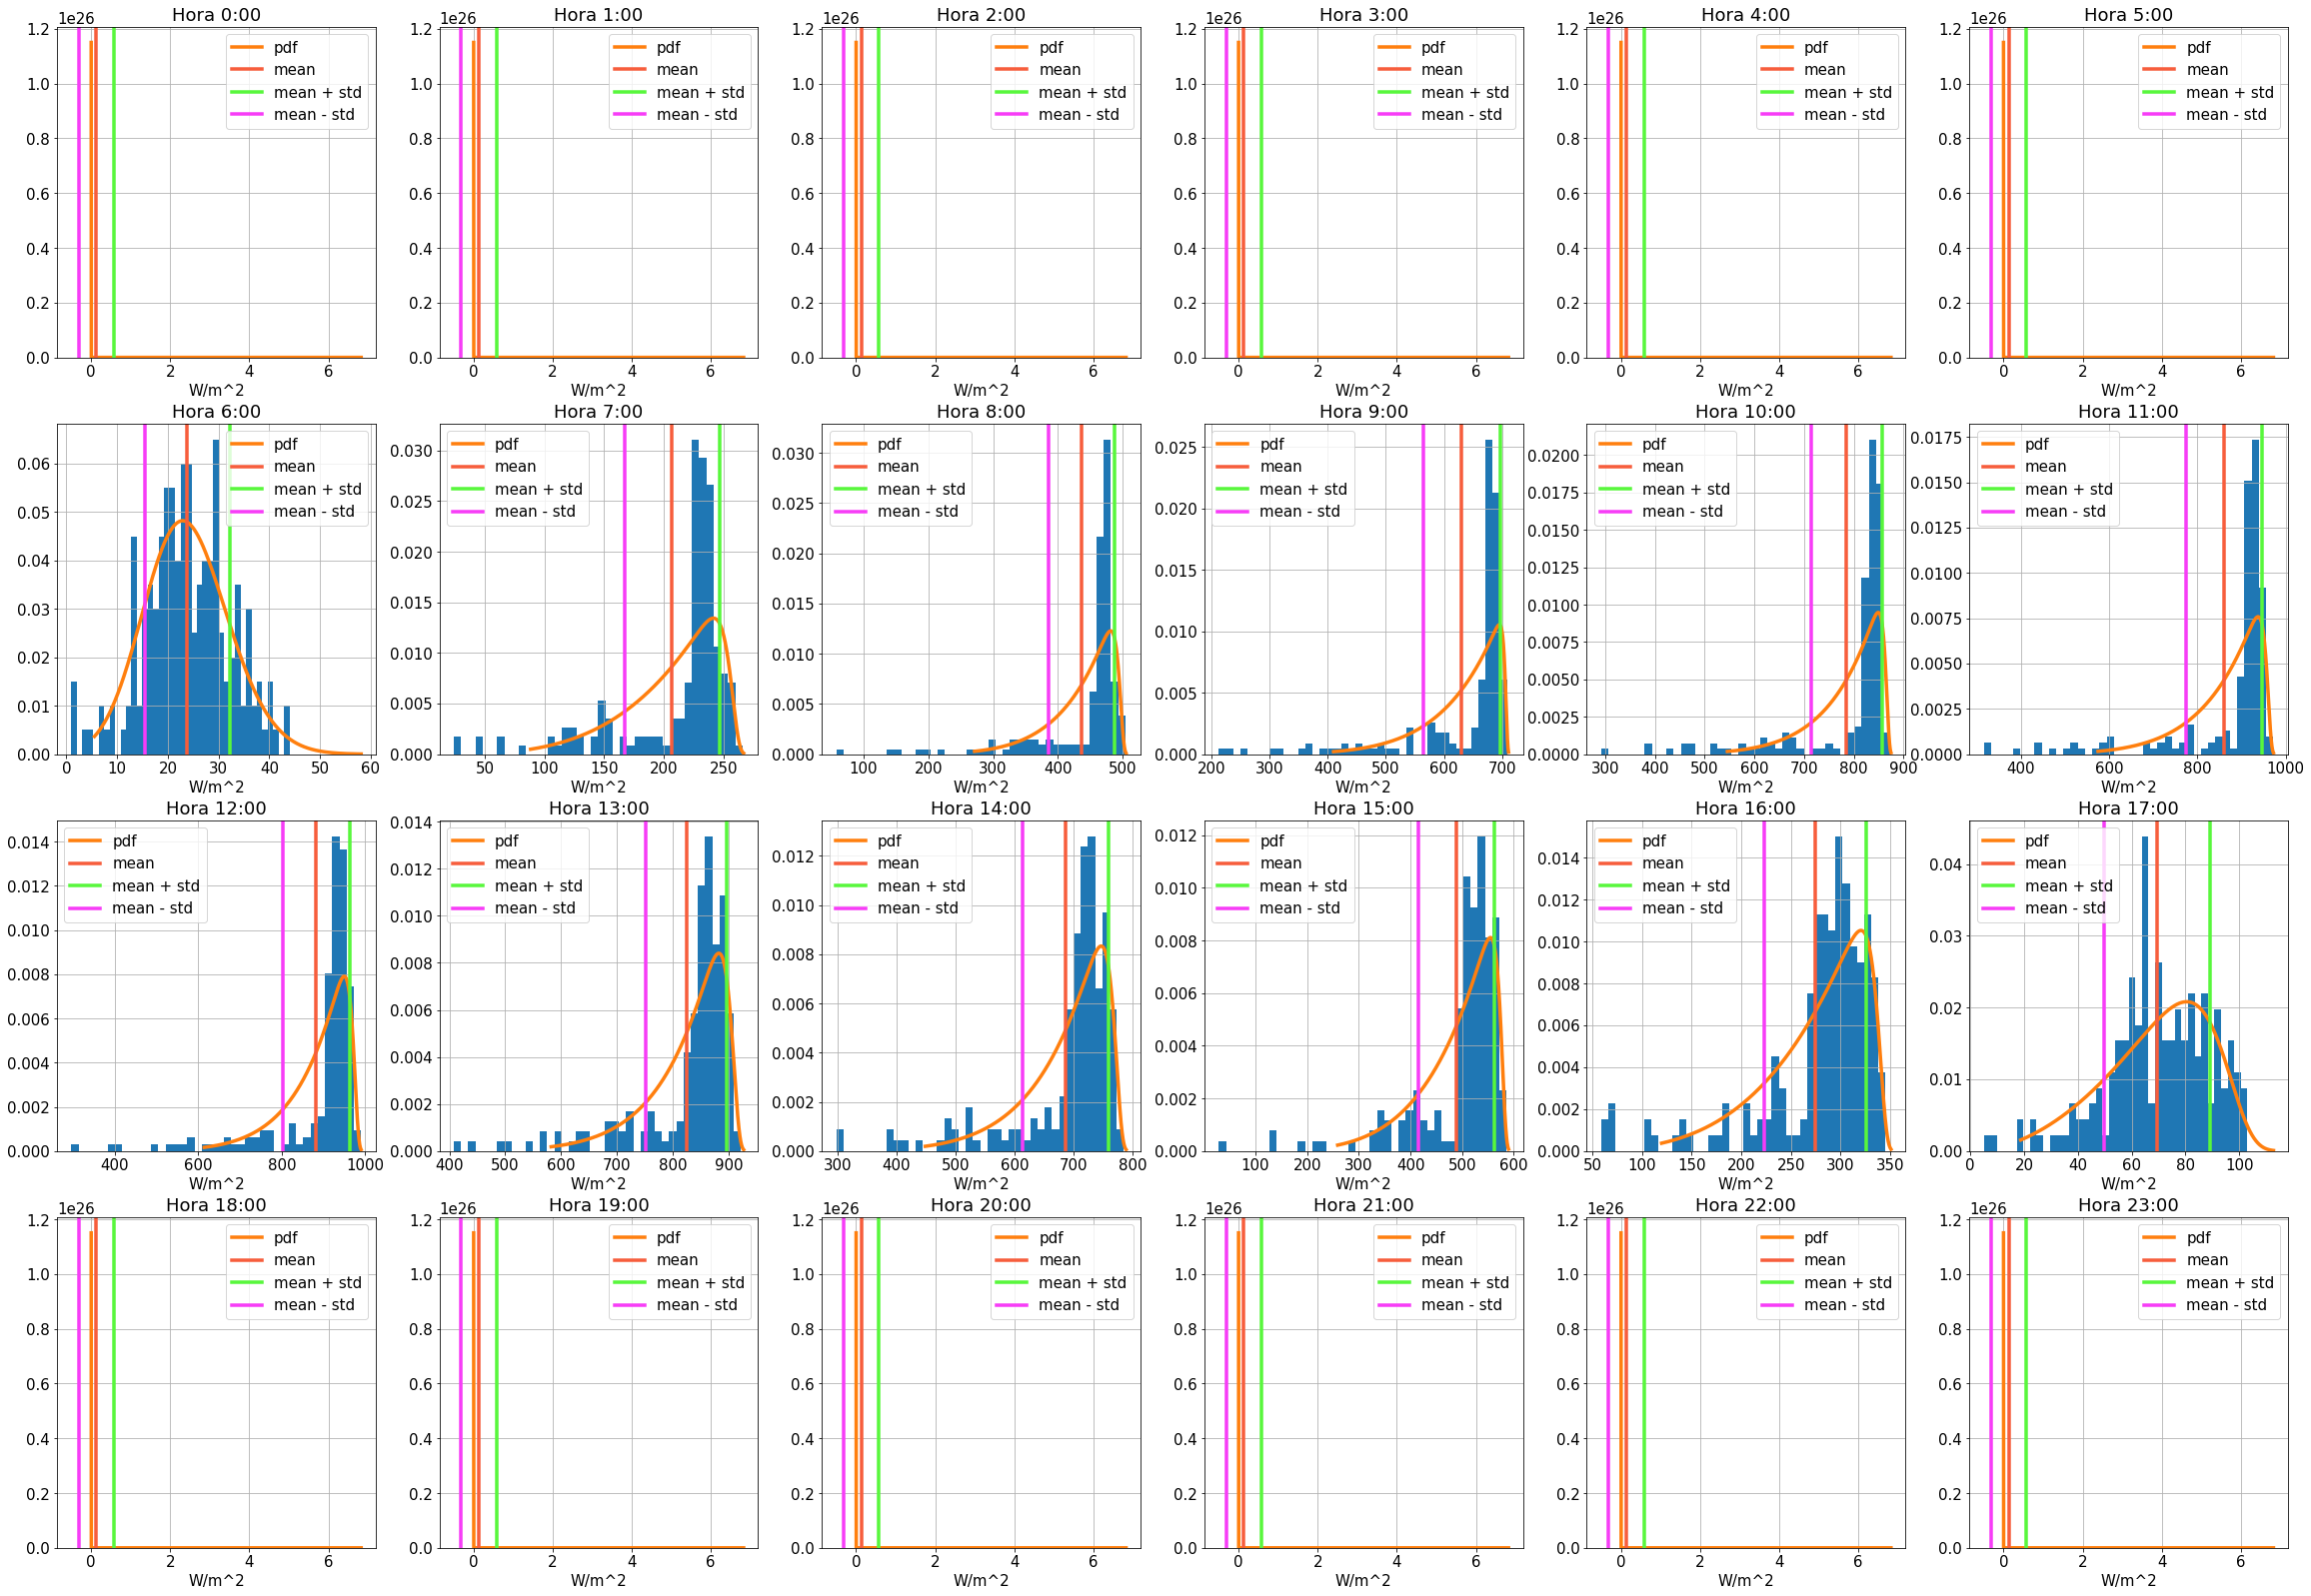

In [18]:
from scipy.stats import exponweib

fig = plot_pdf(df = df, pdf = exponweib, col_data = "GHI", month = 1, units="W/m^2")

### Creación de escenarios

In [19]:
GHI_scens, GHI_prob = create_weather_BMG_scens(df=df, pdf_scipy=exponweib, col="GHI", seed=15)
wind_scens, wind_prob = create_weather_BMG_scens(df=df, pdf_scipy=exponweib, col="Wind Speed", seed=15)

### Guardar escenarios creados

In [20]:
abrv_name = ''.join([i for i in location["name"] if i.isupper()])

GHI_scens[GHI_prob.keys()].to_csv(f'Escenarios/GHI_scens_{abrv_name}.csv', index = False)
with open(f'Escenarios/GHI_prob_{abrv_name}.json', "w") as fp:
    json.dump(GHI_prob,fp) 

wind_scens[wind_prob.keys()].to_csv(f'Escenarios/wind_scens_{abrv_name}.csv', index = False)
with open(f'Escenarios/wind_prob_{abrv_name}.json', "w") as fp:
    json.dump(wind_prob,fp) 

In [21]:
data_fig = [go.Scatter(y=df.loc[df["Year"] == 2020, "GHI"].to_numpy(), name='Históricos de 2020')]
data_fig.extend([go.Scatter(y=GHI_scens[key], name=f'{key} ({np.round(GHI_prob[key],3)})') for key in GHI_prob.keys()])

fig = go.Figure(data=data_fig)
fig.update_layout(title="Escenarios irradiancia", xaxis_title="Fecha", yaxis_title="W/m^2", font=dict(size=14))
fig.show()

In [22]:
data_fig = [go.Scatter(y=df.loc[df["Year"] == 2019, "Wind Speed"].to_numpy(), name='Históricos de 2019')]
data_fig.extend([go.Scatter(y=wind_scens[key], name=f'{key} ({np.round(wind_prob[key],3)})') for key in wind_prob.keys()])

fig = go.Figure(data=data_fig)
fig.update_layout(title="Escenarios velocidad del viento", xaxis_title="Fecha", yaxis_title="m/s", font=dict(size=14))
fig.show()

### Exportar caso determinista

In [23]:
#df.loc[df["Year"] == 2019, ["GHI"]].to_csv(f'Escenarios/GHI_det_{abrv_name}.csv', index = False)
#df.loc[df["Year"] == 2019, ["Wind Speed"]].to_csv(f'Escenarios/wind_det_{abrv_name}.csv', index = False)